### International Trade Agreements: Causal Institutions or Effects of Existing [Rapport]?

This code was for an analysis in a [paper](https://drive.google.com/file/d/1H9gHjocIFn60sOIbf9tkjN2aNYXr32tO/view?usp=sharing) I wrote for a course on international relations theory (Note: the UN Comtrade database has been updated since I originally ran the analysis, so the numbers are slightly different in the paper from the results below; I opted to leave both as they are for now). While I was looking at explicitly economic data (export & import volumes), the research was focused on IR institutional theory, not economic theory per se (though of course they overlap, and I usually abide happily by the dictum that everything is economics). More concretely, the question at hand was whether international trade agreements alter nations' relations significantly, or are they simply manifestations of relations already in place?

I hasten to add that I don't take the findings here as contributing anything to a case against international trade -- I'm a pretty diehard free-trader on both consequentialist and deontological grounds -- but the results might say something interesting about the conditions from which trade agreements arise, i.e. significant international economic connection looks like a prerequisite for agreements rather than the other way around. That's still a loosely held, highly qualified conclusion, and even then, it's not anything the simplest economic theory couldn't offer.

In [1]:
import country_converter as coco
import datetime
import json
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import shutil
import time
import urllib
import wbdata

### A. Processing World Trade Organization Data on Regional Trade Agreements
In the first step we pull the list of countries with bilateral trade agreements concerning goods, from 2000 through 2019. Limiting to those countries will save a good deal of time when access the trade volume data from the UN's Comtrade API. To make for easy merging, the country names are standardized using the [country-converter](https://pypi.org/project/country-converter/) package.

The data come from the World Trade Organization's [Regional Trade Agreements Database](http://rtais.wto.org/UI/PublicMaintainRTAHome.aspx).

In [ ]:
dirname = os.getcwd()
print('Output will be deposited here:', dirname)
outpath = os.path.join(dirname,'Output/')

if not os.path.exists(os.path.join(outpath)):
    os.mkdir(os.path.join(outpath))

#************-----Eventually build in process to download RTA data programmatically, -----------------***************
#************-----but downloading files behind .aspx links seems more complicated than it's worth-----***************
#*********************************************************************************************
# Process would look something like this
# rta_url = 'http://rtais.wto.org/UI/ExportAllRTAList.aspx'
# f = requests.get(rta_url)
# # with zipfile.ZipFile(f.content, 'r') as zip_ref:
# #     x = zipfile.ZipFile.extract(zip_ref)

# rta_df = pd.read_excel(io.BytesIO(x.content), sheet_name='AllRTAs', engine='xlrd')
#*********************************************************************************************
#*********************************************************************************************

rta_df = pd.read_excel("AllRTAs.xls", sheet_name="AllRTAs")

rta_df = rta_df.loc[rta_df['Date of Entry into Force (G)'] > datetime.datetime(1999, 12, 31)]
rta_df = rta_df.loc[rta_df['Date of Entry into Force (G)'] < datetime.datetime(2020, 1, 1)]
rta_df = rta_df.loc[rta_df['RTA Composition'] == 'Bilateral']
rta_df = rta_df.loc[rta_df['Coverage'] != 'Services']

# get list of countries included in trade agreements data to limit pull from Comtrade
tmp = rta_df['Original signatories'].tolist()
tmp = [x for x in tmp if pd.isnull(x) == False]

rta_participants = []
for i in tmp:
    rta_participants += [j.strip() for j in i.split(';')]

rta_participants = list(set(rta_participants))
rta_participants = coco.convert(names=rta_participants, to='name_short')

### B. Gathering UN Comtrade Data

Next, we take the list of countries for which trade data are available in [Comtrade](https://comtradeplus.un.org/TradeFlow) and standardize country naming conventions in the same way the WTO list was in the cell above, so we have a consistent link across data sources. 

Country names seem simple enough, but there's a good deal of variation in notation across data providers, e.g. US, USA, United States; Republic of Korea, South Korea, ROK, 'and' vs '&,' periods or no periods in abbreviations, etc. 

A handful of nations crop up as having no standardized name, but nearly all of these either didn't exist during study period or don't appear in the trade agreements data. One of these nations (Serbia and Montenegro) did overlap a bit (2000-2006) with the analysis window and ostensibly entered two bilateral goods trade agreements in the RTA data. But Comtrade only has data through 2004 for the erstwhile country, and, therefore, we don't have a post-period to work with anyway, so that case doesn't need to handled.

In [3]:
reporting_nations_url = 'https://comtrade.un.org/Data/cache/reporterAreas.json'
f = requests.get(reporting_nations_url)
un_reporting_nations = json.loads(f.content.decode('utf-8-sig'))
un_reporting_nations = un_reporting_nations['results']

for i in un_reporting_nations:
    i['country'] = coco.convert(i['text'], to='name_short')

All not found in ISO3
Belgium-Luxembourg not found in regex
Bonaire not found in regex
EU not found in ISO2
Fmr Pacific Isds not found in regex
Fmr Tanganyika not found in regex
Fmr USSR not found in regex
Fmr Yugoslavia not found in regex
Fmr Zanzibar and Pemba Isd not found in regex
Neth. Antilles not found in regex
Other Asia, nes not found in regex
Ryukyu Isd not found in regex
Sabah not found in regex
More then one regular expression match for Saint Kitts, Nevis and Anguilla
More then one regular expression match for Saint Kitts, Nevis and Anguilla
More then one regular expression match for Saint Kitts, Nevis and Anguilla
More then one regular expression match for Saint Kitts, Nevis and Anguilla
More then one regular expression match for Saint Kitts, Nevis and Anguilla
More then one regular expression match for Saint Kitts, Nevis and Anguilla
More then one regular expression match for Saint Kitts, Nevis and Anguilla
More then one regular expression match for Saint Kitts, Nevis and

This stage has a bit of setup to account for hiccups in API calls due to rate limits and such. Namely, a csv to which data will be appended and a text file to track which country-year combos have already been pulled. This way, in case something goes wrong with the API calls, the program won't pull data which have already been saved in the csv.

In [4]:
trade_data_outfile = 'un_comtrade.csv'
trade_data_outpath = os.path.join(outpath,trade_data_outfile)

#--- CSV to which data will be appended for every country-year request
columns_for_use = ['Year','Trade Flow','Reporter','Reporter Code','Reporter ISO','Partner','Partner Code','Partner ISO','Commodity Code','Trade Value (US$)']

if not os.path.exists(trade_data_outpath):
    pd.DataFrame(columns = columns_for_use).to_csv(trade_data_outpath, index=False)

#--- Text file for tracking which country-years have been downloaded 
completed_file = 'downloaded.txt'
completed_path = os.path.join(outpath,completed_file)

if not os.path.exists(completed_path):
   with open(completed_path, 'w') as file:
       file.write('')

Here we are looping through country-year combos to accrue our dataset. It's a bit ugly and logically repetitive, but the Comtrade API has somewhat stringent allowances for the number of reporting countries, partner countries and years specified in a single query. Namely, [only one](https://comtrade.un.org/data/doc/api#:~:text=Parameter%20combination%20limit%3A%20ps%2C%20r%20and%20p%20are%20limited%20to%205%20codes%20each.%20Only%20one%20of%20the%20above%20codes%20may%20use%20the%20special%20ALL%20value%20in%20a%20given%20API%20call.%20Classification%20codes%20(cc)%20are%20limited%20to%2020%20items.%20ALL%20is%20always%20a%20valid%20classification%20code.) of the reporter, partner and year parameters may call _all_ results for that parameter.

The API also limits to 100 requests per hour, for non-premium users anyway.

With all of that in mind, calls are limited to countries which appear in the trade agreements data, and once data for a given country-year are on hand in the csv, that combo is logged in the text file initiated above. There's probably a more efficient way to log and check whether a combo has already been pulled, but this simple means does the trick. There's also some simple error handling to account for the rate limit: when the limit is reached, the program just hangs out for an hour.

In [5]:
count = 1

for i in un_reporting_nations:
        if i['country'] in rta_participants:
            for year in range(2000,2020):
                with open(completed_path, 'r', encoding='ISO-8859-1') as handle:
                    completed_list = handle.read().split('\n')
                while f"{str(i['id'])}-{str(i['text'])}-{year}" not in completed_list:
                    try:
                        print(f"Iteration {count}; executing id: {i['id']}; UN name: {i['text']}; Std. name: {i['country']}; year: {year}")
                        df = pd.read_csv(f"https://comtrade.un.org/api/get?freq=A&px=HS&ps={year}&r={i['id']}&p=all&rg=all&cc=TOTAL&fmt=csv")
                        df.filter(columns_for_use).to_csv(trade_data_outpath, header=0, mode='a', index=False)
                        with open(completed_path, 'a') as file:
                            file.write(f"{str(i['id'])}-{str(i['text'])}-{year}\n")
                        completed_list.append(f"{str(i['id'])}-{str(i['text'])}-{year}")
                        count += 1
                    except urllib.error.HTTPError:
                        print(f'Request rejected at {datetime.datetime.now().strftime("%H:%M:%S")} -- waiting ~1 hour before resuming API calls')
                        time.sleep(60.01*60)

print('\n\n************************* Comtrade Download Complete*************************')



************************* Comtrade Download Complete*************************


### C. Merge WTO agreements data and UN trade data

Next we'll merge the WTO data on bilateral trade agreements with the UN Comtrade data on import and export volume. This is where the standardized country names come in especially handy.

A mildly eyebrow-raising step here is making a copy of the trade agreements data, swapping signatory 1 & 2, and then stacking that copy with the original. I do this because I want to consider each signatory's trade independently, so stacking after the swap allows each party to be analyzed as a primary party. For example, Chile & Nicaragua signed a trade deal in 2012. In the raw data, Chile is listed first (presumably is just alphabetically sorted), so if we merge on just signatory 1, we wouldn't be catching Nicaragua's moves there. I could just do a second join on signatory 2, but I like this way better because then I don't have to coalesce the columns pulled in from multiple merges.

In [6]:
rta_df = rta_df.filter(['RTA Name','Date of Entry into Force (G)','Original signatories','Coverage','RTA Composition'])
rta_df['Signatory1'] = rta_df['Original signatories'].str.split(';').str[0].str.strip()
rta_df['Signatory2'] = rta_df['Original signatories'].str.split(';').str[1].str.strip()
rta_df = rta_df.loc[rta_df['Signatory2'].notna()]

cc_pd = coco.CountryConverter()
for sig in ['Signatory1','Signatory2']:
    rta_df[f'{sig}_std'] = cc_pd.pandas_convert(series=rta_df[sig], to='name_short')    

rta_df['Agreement Year'] = rta_df['Date of Entry into Force (G)'].dt.strftime('%Y').astype(int)

# Make a copy of the trade agreements to catch both directions of the trade agreements when merging with trade data
rta2 = rta_df.copy()
rta2 = rta2.rename(columns={
    'Signatory1_std':'Signatory2_std',
    'Signatory2_std':'Signatory1_std',
    'Signatory1':'Signatory2',
    'Signatory2':'Signatory1'
    })

rta_df = pd.concat([rta_df, rta2])

It's pretty time-intensive to gather the trade data, so making a copy of those files in a backup folder before manipulating the data at all, just in case.

In [ ]:
backup_path = os.path.join(dirname,'Pre-manipulation backups')
time_label = str(datetime.datetime.now()).replace(':','_')
shutil.copytree(src=outpath, dst=os.path.join(backup_path,f'at_{time_label}'))

Some pivoting, name-standardizing, and dropping non-country partner observations (and Serbia & Montenegro) from the trade data.

In [8]:
trade_df = pd.read_csv(trade_data_outpath)
trade_df = trade_df.loc[trade_df['Year'].isnull()==False]
trade_df = trade_df.pivot_table(index=['Year','Reporter','Reporter Code','Partner','Partner Code','Commodity Code'], columns='Trade Flow', values='Trade Value (US$)').reset_index().drop(['Re-Export','Re-Import'], axis=1)
world_trade = trade_df.loc[trade_df['Partner']=='World'].rename(columns={'Export':'World Exports','Import':'World Imports'}).drop(['Partner','Partner Code'], axis=1)
trade_df = trade_df.loc[trade_df['Partner']!='World']
trade_df = pd.merge(trade_df, world_trade, how='left', on=['Reporter','Reporter Code','Year','Commodity Code'])

drop_list = [
    'Areas, nes',
    'Bonaire',
    'Br. Antarctic Terr.',
    'Bunkers',
    'Free Zones',
    'LAIA, nes',
    'Neth. Antilles',
    'Neutral Zone',
    'North America and Central America, nes',
    'Oceania, nes',
    'Other Africa, nes',
    'Other Asia, nes',
    'Other Europe, nes',
    'Rest of America, nes',
    'Serbia and Montenegro',
    'Special Categories',
    'US Misc. Pacific Isds'
]

trade_df = trade_df.loc[~trade_df['Partner'].isin(drop_list)]

trade_df['Reporter_std'] = cc_pd.pandas_convert(series=trade_df['Reporter'], to='name_short')   
trade_df['Partner_std'] = cc_pd.pandas_convert(series=trade_df['Partner'], to='name_short')

assert len(trade_df)==len(trade_df.drop_duplicates(subset=['Year','Reporter_std','Partner_std']))

Here, we finally get to do the merge and line up all the data for analysis. There are some instances in which Comtrade has data for exports between two countries, but not imports. These are dropposed because we are interested in total trade. And of course we're dropping all trade observations for which we don't have trade agreements to analyze since the question at hand concerns the institutional effect of agreements.

In [9]:
bt = pd.merge(trade_df, rta_df, how='left', left_on = ['Reporter_std','Partner_std'], right_on=['Signatory1_std','Signatory2_std'])
assert len(bt) == len(trade_df)
bt = bt.loc[bt['Agreement Year'].notna()]
bt = bt.loc[(bt['Export'].notna()) & (bt['Import'].notna())]
bt = bt.loc[(bt['World Exports'].notna()) & (bt['World Imports'].notna())]


bt['Total Partner Trade'] = bt['Export'] + bt['Import']
bt['Total World Trade'] = bt['World Exports'] + bt['World Imports']

bt = bt.rename(columns={'RTA Name':'RTA_Name'})
bt['Agreement_Index'] = bt['Year'] - bt['Agreement Year']
bt['key'] = bt['Reporter_std'].str.cat(bt['Partner_std'], sep='-')

assert len(bt) == len(bt.drop_duplicates(subset=['Year','Reporter_std','Partner_std']))

We'll also go ahead and merge GDP data from the World Bank with the trade data. This is really easy thanks to the [wbdata](https://pypi.org/project/wbdata/) package. We're using nominal GDP here because the trade data are also in nominal terms, so it should even out, at least roughly. Adjusting for inflation would require distinct deflators for each country, and that's a bit complex for the scale of this project.

In [10]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2019, 1, 1)
dates = [start, end]
gdp = wbdata.get_dataframe({"NY.GDP.MKTP.CD":"GDP"},data_date=dates, freq='Y').reset_index()
gdp['date'] = gdp['date'].astype(int)
gdp['country_std'] = cc_pd.pandas_convert(series=gdp['country'], to='name_short')

old_bt_len = len(bt)
bt = pd.merge(bt, gdp, how='left', left_on=['Reporter_std','Year'], right_on = ['country_std','date'])
bt['key_un'] = bt['Reporter'].str.cat(bt['Partner'], sep='-')
bt.to_csv(outpath+'bt_202303.csv', index=False)
assert len(bt) == old_bt_len

### D. Analysis

Setting up a couple functions for analysis here. In all of these the Agreement Index is very important. This is simply the year for the trade data minus the year of the relevant trade agreement. So for a trade agreement signed in 2010, 2005 would be index year -5, 2010 would be 0, and 2014 would be index year 4.
- ```window_n``` takes an integer to serve as observation window around initiation of the trade agreement, and returns a dataframe containing only trade relationships for which data are available across _all years_ in the given window.
- ```pre_post_rates``` calculates the growth rates of a given variable within the pre (e.g. -5 through -1) and post (e.g. 0 through 4) periods, as well as from the first period through the last one (e.g. -5 through 4).
- ```avg_growth_rates``` averages annual growth rates across all bilateral relationships in the input data.
- ```index_trend``` indexes a series' volume to its value in the earliest period

In [11]:
def window_n(years: int) -> pd.DataFrame:
    pool = pd.DataFrame(bt['key'].unique(), columns=['key'])

    for i in range(years*(-1),years):
        avail = bt.loc[bt['Agreement_Index'] == i].filter(['key'], axis=1)
        pool = pd.merge(pool,avail, how='inner', on='key')

    print('Trade relationships available with '+str(years)+' year(s) pre and post agreement: '+str(len(pool)))
    units = pool['key'].tolist()
    df = bt[bt['key'].isin(units)]

    df = df.loc[df['Agreement_Index']>=(years*(-1))]
    df = df.loc[df['Agreement_Index']<years]

    return df


def pre_post_rates(in_df: pd.DataFrame, var: str, window: int) -> pd.DataFrame:
    '''Growth rates within the pre- and post-agreement periods and across the full window.'''
    align = {
        -1*window:f'{var}_pre_start',
        -1:f'{var}_pre_end',
        0:f'{var}_post_start',
        window-1:f'{var}_post_end'
    }

    df = in_df.loc[in_df['Agreement_Index'].isin(align.keys())].copy()
    df['Sub_period'] = df['Agreement_Index'].map(align)
    df = df.pivot_table(index=['key','Reporter_std','Partner_std'], columns='Sub_period', values=var).reset_index()
    df[f'{var} Intra-Pre Period % Change'] = df[f'{var}_pre_end']/df[f'{var}_pre_start'] - 1
    df[f'{var} Intra-Post Period % Change'] = df[f'{var}_post_end']/df[f'{var}_post_start'] - 1
    df[f'{var} Full Window % Change'] = df[f'{var}_post_end']/df[f'{var}_pre_start'] - 1
    return df


def avg_growth_rates(in_df: pd.DataFrame, var: str) -> pd.DataFrame:
    '''Returns'''
    df = in_df.sort_values(['Reporter_std','Partner_std','Year'])
    df[f'{var} Annual Growth Rate'] = df.groupby('key')[['Total Partner Trade']].diff().fillna(0)/df.groupby('key')[['Total Partner Trade']].shift(1)
    return df.groupby('Agreement_Index')[[f'{var} Annual Growth Rate']].mean().reset_index()


def index_trend(in_df: pd.DataFrame, var:str, index_loc = -99) -> pd.DataFrame:
    df = in_df.sort_values(['Reporter_std','Partner_std','Year'])
    if index_loc < df['Agreement_Index'].min():
        index_loc = df['Agreement_Index'].min()
    tmp = df.loc[df['Agreement_Index']==index_loc]
    tmp = tmp.filter(['key',var], axis=1).rename(columns={var:'index_base'})
    df = pd.merge(df,tmp, how='left',on='key')
    df[f'{var} Relative to Year {index_loc}'] = df[var]/df['index_base']
    out = df.groupby('Agreement_Index')[[f'{var} Relative to Year {index_loc}']].mean().reset_index()
    out = out.loc[out['Agreement_Index'] != out['Agreement_Index'].min()]
    return out


def standardized_trend(in_df: pd.DataFrame, vars: list, base_year: int, label: str):
    renames = {i:f'{i}_base' for i in vars}
    base_df = in_df.loc[in_df['Agreement_Index']==base_year].rename(columns=renames).filter(['key']+list(renames.values()))
    tmp = pd.merge(in_df, base_df, how='left', on='key')
    for var in vars:
        tmp[f'{var}_std'] = tmp[var]/tmp[f'{var}_base']*100
    tmp = tmp.groupby('Agreement_Index')[[f'{var}_std' for var in vars]].mean()
    # tmp[[f'{var}_std' for var in vars]].plot()
    plt.plot(tmp[[f'{var}_std' for var in vars]])
    plt.axvspan(0, base_year*-1, facecolor='grey', alpha=0.5)
    plt.legend([i for i in vars])
    plt.xlabel('Years since Bilateral Trade Agreement')
    plt.ylabel(f'Relative to Year {base_year} (100)')
    plt.xlim([base_year, base_year*-1])
    plt.savefig(f'{outpath}/{label}.png', dpi=600)
    plt.show()
    plt.close()

I could batch these and get all possible output for all combinations of variables considered, but I think it's easier to follow if just going step by step through the tables I originally used in the paper. I can think of lots of other comparisons I'd like to see now too, but sticking with original for now.

In [12]:
counts = pd.DataFrame(columns=['key','Reporter_std','Partner_std'])

for i in range(2,7):
    df = window_n(i)
    tmp_w = pd.DataFrame(columns=['key','Reporter_std','Partner_std'])
    for measure in ['Total Partner Trade','Total World Trade','GDP']:
        tmp_m = pre_post_rates(df, var = measure, window=i)
        tmp_w = pd.merge(tmp_w, tmp_m, how='outer',on=['key','Reporter_std','Partner_std'])
    tmp_w['window'] = f'+/-{i} years'
    counts = pd.concat([counts, tmp_w])


counts.loc[counts['Total Partner Trade Full Window % Change'] > counts['Total World Trade Full Window % Change'], 'Partner Trade v. World Trade'] = 'Partner % Change > World'
counts.loc[counts['Total Partner Trade Full Window % Change'] < counts['Total World Trade Full Window % Change'], 'Partner Trade v. World Trade'] = 'Partner % Change < World'

counts.loc[counts['Total Partner Trade Full Window % Change'] > counts['GDP Full Window % Change'], 'Partner Trade v. GDP'] = 'Partner % Change > GDP'
counts.loc[counts['Total Partner Trade Full Window % Change'] < counts['GDP Full Window % Change'], 'Partner Trade v. GDP'] = 'Partner % Change < GDP'

counts.loc[counts['Total Partner Trade Intra-Pre Period % Change'] > counts['Total Partner Trade Intra-Post Period % Change'], 'Partner Trade Pre v. Partner Trade Post'] = 'Partner % Change Pre > Partner % Change Post'
counts.loc[counts['Total Partner Trade Intra-Pre Period % Change'] < counts['Total Partner Trade Intra-Post Period % Change'], 'Partner Trade Pre v. Partner Trade Post'] = 'Partner % Change Pre < Partner % Change Post'

Trade relationships available with 2 year(s) pre and post agreement: 277
Trade relationships available with 3 year(s) pre and post agreement: 254
Trade relationships available with 4 year(s) pre and post agreement: 218
Trade relationships available with 5 year(s) pre and post agreement: 180
Trade relationships available with 6 year(s) pre and post agreement: 142


In [13]:
def fmt_output(analysis_var: str, numerator: str, pct_label: str) -> pd.DataFrame:
    out = counts.groupby(['window',analysis_var]).size().reset_index(name='Count')
    totals = out.groupby('window')[['Count']].sum().rename(columns={'Count':'N'})
    out = out.pivot_table(index='window', columns=analysis_var, values='Count')
    out = pd.merge(out, totals, how='left', on='window').reset_index()
    out[pct_label] = (out[numerator]/out['N']).astype(float).map("{:.1%}".format)
    # out.style.format({pct_label: '{:,.2%}'.format})
    cols = ['window','N']+[i for i in out.columns if i not in ['window','N']]
    out = out[cols]
    return out

table1 = fmt_output('Partner Trade v. World Trade', numerator='Partner % Change > World', pct_label='%\u0394TP > %\u0394WT')
table1.to_csv(outpath+'table1.csv', index=False)
table1

,window,N,Partner % Change < World,Partner % Change > World,%ΔTP > %ΔWT
0,+/-2 years,277,113,164,59.2%
1,+/-3 years,254,84,170,66.9%
2,+/-4 years,218,68,150,68.8%
3,+/-5 years,180,56,124,68.9%
4,+/-6 years,142,45,97,68.3%


Trade relationships available with 6 year(s) pre and post agreement: 142


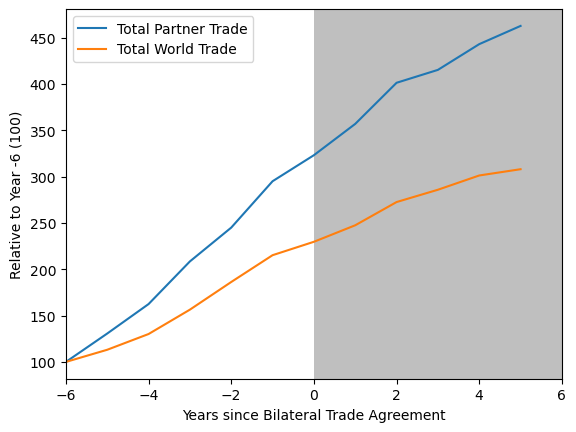

In [14]:
figure1 = standardized_trend(in_df=window_n(6), vars=['Total Partner Trade','Total World Trade'], base_year=-6, label='figure1')

In [15]:
table2 = fmt_output('Partner Trade v. GDP', numerator='Partner % Change > GDP', pct_label='%\u0394TP > %\u0394GDP')
table2.to_csv(outpath+'table2.csv', index=False)
table2

,window,N,Partner % Change < GDP,Partner % Change > GDP,%ΔTP > %ΔGDP
0,+/-2 years,277,114,163,58.8%
1,+/-3 years,254,92,162,63.8%
2,+/-4 years,218,80,138,63.3%
3,+/-5 years,180,68,112,62.2%
4,+/-6 years,142,51,91,64.1%


Trade relationships available with 6 year(s) pre and post agreement: 142


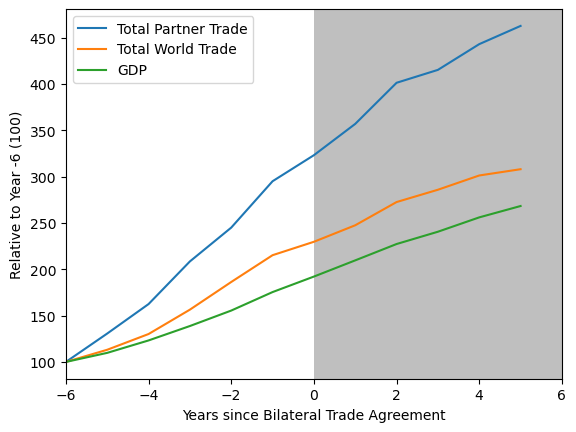

In [16]:
figure2 = standardized_trend(in_df=window_n(6), vars=['Total Partner Trade','Total World Trade','GDP'], base_year=-6, label='figure2')

In [17]:
table3 = fmt_output('Partner Trade Pre v. Partner Trade Post', numerator='Partner % Change Pre < Partner % Change Post', pct_label='%\u0394TP Pre < %\u0394TP Post')
table3.to_csv(outpath+'table3.csv', index=False)
table3

,window,N,Partner % Change Pre < Partner % Change Post,Partner % Change Pre > Partner % Change Post,%ΔTP Pre < %ΔTP Post
0,+/-2 years,277,139,138,50.2%
1,+/-3 years,254,130,124,51.2%
2,+/-4 years,218,88,130,40.4%
3,+/-5 years,180,48,132,26.7%
4,+/-6 years,142,30,112,21.1%


Trade relationships available with 6 year(s) pre and post agreement: 142


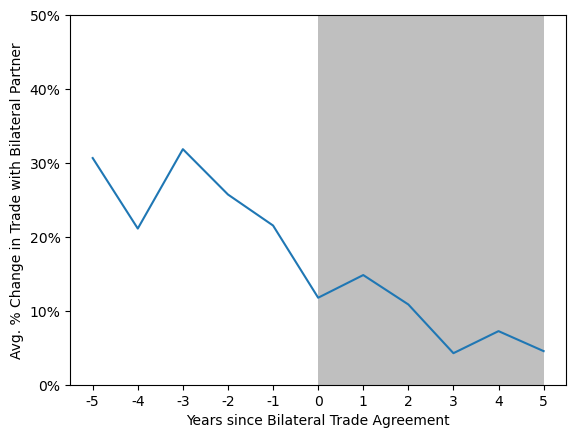

In [18]:
figure3_df = avg_growth_rates(in_df=window_n(6), var='Total Partner Trade')
figure3_df
plt.plot(figure3_df['Total Partner Trade Annual Growth Rate'])
# plt.legend([i for i in vars])
plt.xlabel('Years since Bilateral Trade Agreement')
plt.ylabel(f'Avg. % Change in Trade with Bilateral Partner')
plt.xticks(range(len(figure3_df['Agreement_Index'])),figure3_df['Agreement_Index'].astype(int))
plt.axvspan(6, 11, facecolor='grey', alpha=0.5)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.ylim([0, .5])
plt.savefig(f'{outpath}/figure3.png', dpi=600)
plt.show()
plt.close()

##### List of qualifications:
- Some agreements pertain to only certain sorts of goods, so looking at goods trade in aggregate elides some complexity.
- Simple comparisons of bilateral trade with overall trade don't capture effects of _other_ trade agreements on overall trade.
- Multilateral trade agreements are entirely ignored here.